<a href="https://colab.research.google.com/github/MazoDreX/mpd-unsupervised-learning/blob/main/Unsupervised_Rekomendasi_Playlist_FiturAudio_Mahalanobis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perbandingan K-Means dan Gaussian Mixture Model pada Dataset Playlist Spotify

## Load Data dan menggabungkan data Playlist dan fitur audio dari Track.csv
Data fitur audio diambil dari Kaggle yang berasal dari Spotify API, fitur yang diambil adalah kolom audio seperti dancebility, energy, loudness, dan lain-lain

In [26]:
import pandas as pd
import json
import glob
import os

# --- CONFIGURATION ---
# UPDATE THESE PATHS TO MATCH YOUR FOLDER STRUCTURE
MPD_FOLDER_PATH = '/content/drive/MyDrive/MPD_Dataset/50K'       # Folder with mpd.slice.x.json
TRACKS_CSV_PATH = '/content/drive/MyDrive/MPD_Dataset/Tracks/tracks.csv' # File with audio features
NUM_SLICES_TO_LOAD = 50              # 50 slices = 50,000 playlists

# The strictly continuous features needed for Mahalanobis
AUDIO_COLS = ['danceability', 'energy', 'loudness', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [27]:
def load_and_merge_data():
    print("="*60)
    print("PHASE 1: DATA INGESTION")
    print("="*60)

    # ---------------------------------------------------------
    # 1. LOAD MPD (PLAYLISTS & TRACK RELATIONS)
    # ---------------------------------------------------------
    print(f"1. Loading {NUM_SLICES_TO_LOAD} MPD slices from: {MPD_FOLDER_PATH}")

    mpd_files = sorted(glob.glob(os.path.join(MPD_FOLDER_PATH, "mpd.slice.*.json")))[:NUM_SLICES_TO_LOAD]

    if not mpd_files:
        raise FileNotFoundError(f"No JSON files found in {MPD_FOLDER_PATH}. Please check the path.")

    playlist_data = []

    for file_path in mpd_files:
        with open(file_path, 'r') as f:
            data = json.load(f)
            for playlist in data['playlists']:
                pid = playlist['pid']
                name = playlist.get('name', 'Unknown')

                for track in playlist['tracks']:
                    # IMPORTANT: Clean the ID immediately
                    # "spotify:track:5CtI0qwHG..." -> "5CtI0qwHG..."
                    track_uri = track['track_uri'].split(':')[-1]

                    playlist_data.append({
                        'pid': pid,
                        'playlist_name': name,
                        'track_id': track_uri,
                        'artist_name': track['artist_name'], # Keep metadata for display
                        'track_name': track['track_name']    # Keep metadata for display
                    })

    df_mpd = pd.DataFrame(playlist_data)
    print(f"   > Loaded {df_mpd['pid'].nunique()} playlists containing {len(df_mpd)} track entries.")

    # ---------------------------------------------------------
    # 2. LOAD AUDIO FEATURES (CSV)
    # ---------------------------------------------------------
    print(f"\n2. Loading Audio Features from: {TRACKS_CSV_PATH}")

    # Only load necessary columns to save RAM
    # We assume the CSV has an 'id' column for the track ID
    cols_to_load = ['id'] + AUDIO_COLS

    try:
        df_features = pd.read_csv(TRACKS_CSV_PATH, usecols=cols_to_load)
    except ValueError as e:
        print("   ⚠️ Error loading specific columns. Trying to load all and rename...")
        # Fallback if column names differ (e.g., 'track_id' instead of 'id')
        df_features = pd.read_csv(TRACKS_CSV_PATH)

    # RENAME ID COLUMN TO MATCH MPD
    # Adjust this if your CSV uses 'track_id' or 'uri'
    if 'id' in df_features.columns:
        df_features.rename(columns={'id': 'track_id'}, inplace=True)

    # Drop duplicates (Common issue in aggregated CSVs)
    df_features.drop_duplicates(subset=['track_id'], inplace=True)

    # Ensure audio columns are numeric (Force float, turn errors to NaN)
    for col in AUDIO_COLS:
        df_features[col] = pd.to_numeric(df_features[col], errors='coerce')

    # Drop rows where audio features are missing/corrupted
    df_features.dropna(subset=AUDIO_COLS, inplace=True)

    print(f"   > Loaded unique audio features for {len(df_features)} tracks.")

    # ---------------------------------------------------------
    # 3. MERGE
    # ---------------------------------------------------------
    print("\n3. Merging Datasets...")

    # Inner join: We only keep playlist entries where we have audio data
    df_merged = pd.merge(df_mpd, df_features, on='track_id', how='inner')

    print(f"   > Merge Complete.")
    print(f"   > Total rows (Tracks in Playlists): {len(df_merged)}")
    print(f"   > Unique Playlists with Data: {df_merged['pid'].nunique()}")

    # ---------------------------------------------------------
    # 4. FINAL CLEANUP
    # ---------------------------------------------------------
    # Filter out tiny playlists (need > 15 songs for Mahalanobis math)
    print("\n4. Filtering small playlists (< 15 songs)...")
    playlist_counts = df_merged['pid'].value_counts()
    valid_pids = playlist_counts[playlist_counts >= 15].index

    df_final_merged = df_merged[df_merged['pid'].isin(valid_pids)].copy()

    print(f"   > Final Dataset ready for Cleaning: {len(df_final_merged)} rows.")
    print(f"   > Playlists remaining: {df_final_merged['pid'].nunique()}")

    return df_final_merged

In [28]:
# --- EXECUTE ---
# Run this once to get your raw data variable
df_raw = load_and_merge_data()

# Show sample
print("\nSample Data:")
print(df_raw[['pid', 'track_name', 'energy', 'tempo']].head())

PHASE 1: DATA INGESTION
1. Loading 50 MPD slices from: /content/drive/MyDrive/MPD_Dataset/50K
   > Loaded 50000 playlists containing 3344374 track entries.

2. Loading Audio Features from: /content/drive/MyDrive/MPD_Dataset/Tracks/tracks.csv
   > Loaded unique audio features for 586672 tracks.

3. Merging Datasets...
   > Merge Complete.
   > Total rows (Tracks in Playlists): 1396778
   > Unique Playlists with Data: 48901

4. Filtering small playlists (< 15 songs)...
   > Final Dataset ready for Cleaning: 1256064 rows.
   > Playlists remaining: 29596

Sample Data:
   pid                                  track_name  energy    tempo
0    0  Lose Control (feat. Ciara & Fat Man Scoop)   0.813  125.461
1    0                                       Toxic   0.838  143.040
2    0                               Crazy In Love   0.758   99.259
3    0                              Rock Your Body   0.714  100.972
4    0                                      My Boo   0.507   86.412


## Data Preprocessing menggunakan Jarak Mahalanobis untuk Membersihkan lagu yang kurang mirip pada sebuah playlist
Playlist lagu yang dibuat oleh user bisa sangat acak dan tergantung dari selera user, untuk membuat clustering yang lebih koheren maka berbagai lagu yang kurang mirip dari sebagian besar lagu harus dihilangkan

In [29]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
AUDIO_COLS = ['danceability', 'energy', 'loudness', 'speechiness',
              'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

print("="*60)
print("PHASE 2: MAHALANOBIS CLEANING & FEATURE ENGINEERING")
print("="*60)

PHASE 2: MAHALANOBIS CLEANING & FEATURE ENGINEERING


In [30]:
# ---------------------------------------------------------
# 1. DEFINE THE CLEANER FUNCTION
# ---------------------------------------------------------
def clean_playlist_mahalanobis(df_playlist):
    """
    Calculates the Mahalanobis distance for every song in the playlist.
    Removes the top 10% of songs that are statistically distant from the playlist's core vibe.
    """
    # Safety Check: Need enough data points (> 10) to calculate covariance matrix safely
    if len(df_playlist) < 15:
        return df_playlist

    # Extract the feature matrix
    X = df_playlist[AUDIO_COLS].values

    try:
        # 1. Calculate Covariance Matrix & Inverse
        cov_matrix = np.cov(X.T)

        # Add tiny noise to diagonal to prevent singular matrix errors (if variance is 0)
        cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-6

        inv_cov_matrix = np.linalg.inv(cov_matrix)

        # 2. Calculate Mean Vector
        mean_dist = X.mean(axis=0)

        # 3. Calculate Mahalanobis Distance for each song
        def get_dist(row):
            return mahalanobis(row, mean_dist, inv_cov_matrix)

        distances = np.apply_along_axis(get_dist, 1, X)

        # 4. Filter: Remove top 10% outliers
        limit = np.percentile(distances, 90) # Threshold at 90th percentile
        clean_mask = distances < limit

        return df_playlist[clean_mask]

    except Exception as e:
        # Fallback: If math fails (rare), return original playlist
        return df_playlist



In [31]:
# ---------------------------------------------------------
# 2. APPLY CLEANING
# ---------------------------------------------------------
print("1. Running Outlier Detection (This may take a minute)...")

# Apply the function to each playlist group
# result is a DataFrame of tracks, but with the "bad" tracks removed
df_clean = df_raw.groupby('pid', group_keys=False).apply(clean_playlist_mahalanobis)

print(f"   > Tracks before cleaning: {len(df_raw)}")
print(f"   > Tracks after cleaning:  {len(df_clean)}")
print(f"   > Removed {len(df_raw) - len(df_clean)} outliers.")

1. Running Outlier Detection (This may take a minute)...
   > Tracks before cleaning: 1256064
   > Tracks after cleaning:  1117392
   > Removed 138672 outliers.


/tmp/ipython-input-3751019932.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_raw.groupby('pid', group_keys=False).apply(clean_playlist_mahalanobis)


In [32]:
# ---------------------------------------------------------
# 3. AGGREGATE (CREATE PLAYLIST VECTORS)
# ---------------------------------------------------------
print("\n2. Creating Audio Profiles (Mean + Std Dev)...")

# Group by PID and calculate Mean and Std for all audio columns
playlist_features = df_clean.groupby('pid')[AUDIO_COLS].agg(['mean', 'std'])

# Flatten column names (e.g. ('energy', 'mean') -> 'energy_mean')
playlist_features.columns = ['_'.join(col) for col in playlist_features.columns]

# Handle NaN std devs (if a playlist shrank to 1 song, std is NaN)
playlist_features = playlist_features.fillna(0)

# Merge back the Playlist Name for reference
# (We take the first name found for each PID)
playlist_names = df_clean.groupby('pid')['playlist_name'].first()
df_final = playlist_features.join(playlist_names)

print(f"   > Final Playlist Matrix Shape: {df_final.shape}")


2. Creating Audio Profiles (Mean + Std Dev)...
   > Final Playlist Matrix Shape: (29595, 19)


In [33]:
# ---------------------------------------------------------
# 4. SCALING (CRITICAL FOR CLUSTERING)
# ---------------------------------------------------------
print("\n3. Scaling Data (StandardScaler)...")

# Separate numerical features from metadata
feature_data = df_final.drop(columns=['playlist_name'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_data)

print(f"   > Scaling complete. X_scaled shape: {X_scaled.shape}")
print("\n✅ READY FOR CLUSTERING.")


3. Scaling Data (StandardScaler)...
   > Scaling complete. X_scaled shape: (29595, 18)

✅ READY FOR CLUSTERING.


## Cari Optimal K dan BIC untuk membuat jumlah cluster yang optimal dan mudah dibedakan

PHASE 3: DETERMINING OPTIMAL CLUSTER COUNT (K)
Testing K=2 to 15...
   K=2: Silhouette=0.2223 | BIC=810101
   K=3: Silhouette=0.1553 | BIC=713399
   K=4: Silhouette=0.1685 | BIC=672193
   K=5: Silhouette=0.1479 | BIC=653153
   K=6: Silhouette=0.1383 | BIC=613873
   K=7: Silhouette=0.1289 | BIC=601741
   K=8: Silhouette=0.1311 | BIC=577449
   K=9: Silhouette=0.1316 | BIC=569934
   K=10: Silhouette=0.1272 | BIC=558531
   K=11: Silhouette=0.1184 | BIC=550899
   K=12: Silhouette=0.1211 | BIC=538807
   K=13: Silhouette=0.1255 | BIC=539662
   K=14: Silhouette=0.1222 | BIC=531974
   K=15: Silhouette=0.1196 | BIC=527851

Optimization finished in 153.22 seconds.


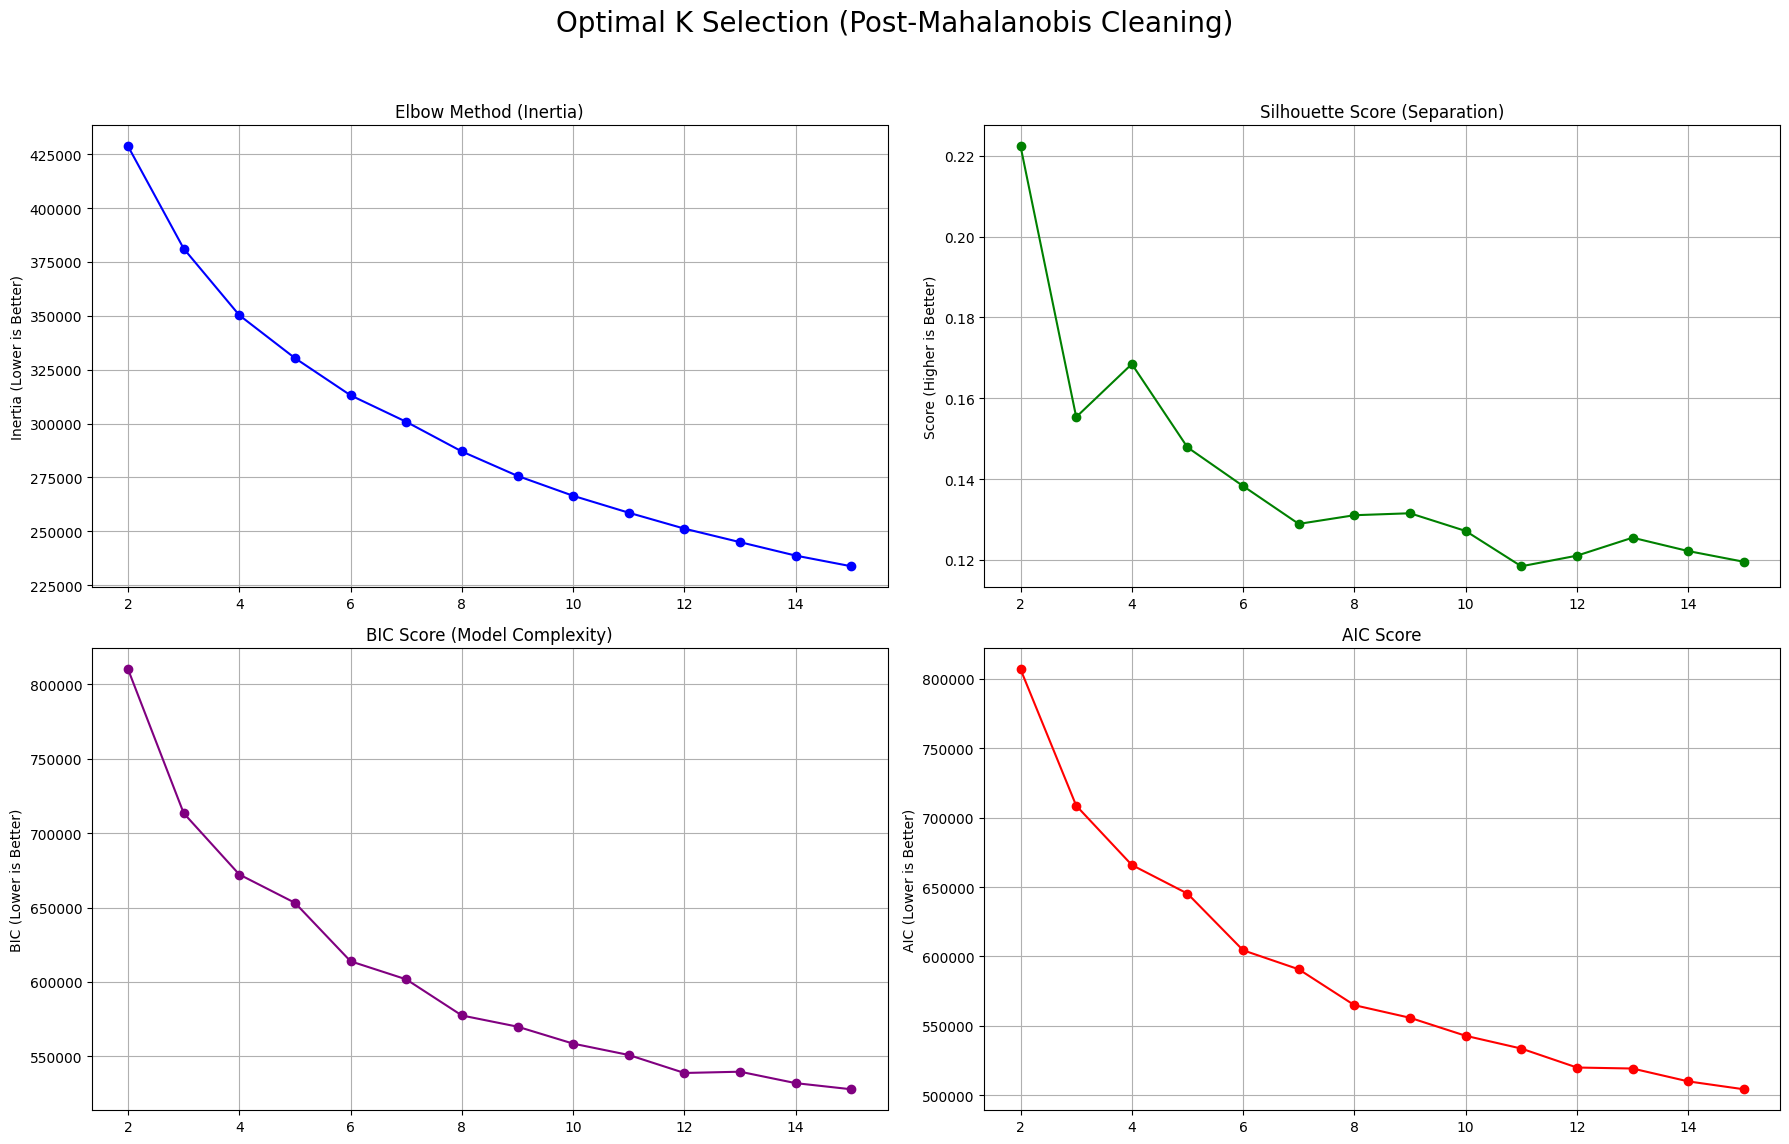

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import time

# --- CONFIGURATION ---
K_RANGE = range(2, 16) # Test clusters from 2 to 15
SAMPLE_SIZE = 10000    # Sample size for Silhouette (speed optimization)
RANDOM_SEED = 42

print("="*60)
print("PHASE 3: DETERMINING OPTIMAL CLUSTER COUNT (K)")
print("="*60)

# Prepare lists to store metrics
kmeans_inertia = []
kmeans_silhouette = []
gmm_bic = []
gmm_aic = []

# Create a fixed sample for consistent silhouette scoring
indices = np.random.choice(X_scaled.shape[0], min(SAMPLE_SIZE, X_scaled.shape[0]), replace=False)
X_sample = X_scaled[indices]

print(f"Testing K=2 to {K_RANGE[-1]}...")
start_time = time.time()

for k in K_RANGE:
    # 1. K-Means Evaluation
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10)
    km.fit(X_scaled)
    kmeans_inertia.append(km.inertia_)

    # Silhouette (Use sample)
    labels_k = km.predict(X_sample)
    score_k = silhouette_score(X_sample, labels_k)
    kmeans_silhouette.append(score_k)

    # 2. GMM Evaluation
    # covariance_type='full' allows flexible cluster shapes
    gm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_SEED)
    gm.fit(X_scaled)
    gmm_bic.append(gm.bic(X_scaled))
    gmm_aic.append(gm.aic(X_scaled))

    print(f"   K={k}: Silhouette={score_k:.4f} | BIC={int(gm.bic(X_scaled))}")

print(f"\nOptimization finished in {time.time() - start_time:.2f} seconds.")

# --- PLOTTING ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Optimal K Selection (Post-Mahalanobis Cleaning)', fontsize=20)

# 1. Elbow Method (Inertia)
axes[0, 0].plot(K_RANGE, kmeans_inertia, marker='o', color='blue')
axes[0, 0].set_title('Elbow Method (Inertia)')
axes[0, 0].set_ylabel('Inertia (Lower is Better)')
axes[0, 0].grid(True)

# 2. Silhouette Score
axes[0, 1].plot(K_RANGE, kmeans_silhouette, marker='o', color='green')
axes[0, 1].set_title('Silhouette Score (Separation)')
axes[0, 1].set_ylabel('Score (Higher is Better)')
axes[0, 1].grid(True)

# 3. BIC Score
axes[1, 0].plot(K_RANGE, gmm_bic, marker='o', color='purple')
axes[1, 0].set_title('BIC Score (Model Complexity)')
axes[1, 0].set_ylabel('BIC (Lower is Better)')
axes[1, 0].grid(True)

# 4. AIC Score
axes[1, 1].plot(K_RANGE, gmm_aic, marker='o', color='red')
axes[1, 1].set_title('AIC Score')
axes[1, 1].set_ylabel('AIC (Lower is Better)')
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from math import pi

# --- CONFIGURATION ---
FINAL_K = 5
print(f"--- Training Final Models (Clean Data, K={FINAL_K}) ---")

# 1. TRAIN MODELS
# K-Means
kmeans_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
df_final['kmeans_label'] = kmeans_final.fit_predict(X_scaled)

# GMM
gmm_final = GaussianMixture(n_components=FINAL_K, covariance_type='full', random_state=42)
gmm_final.fit(X_scaled)
df_final['gmm_label'] = gmm_final.predict(X_scaled)

print("Training Complete.")

--- Training Final Models (Clean Data, K=5) ---
Training Complete.


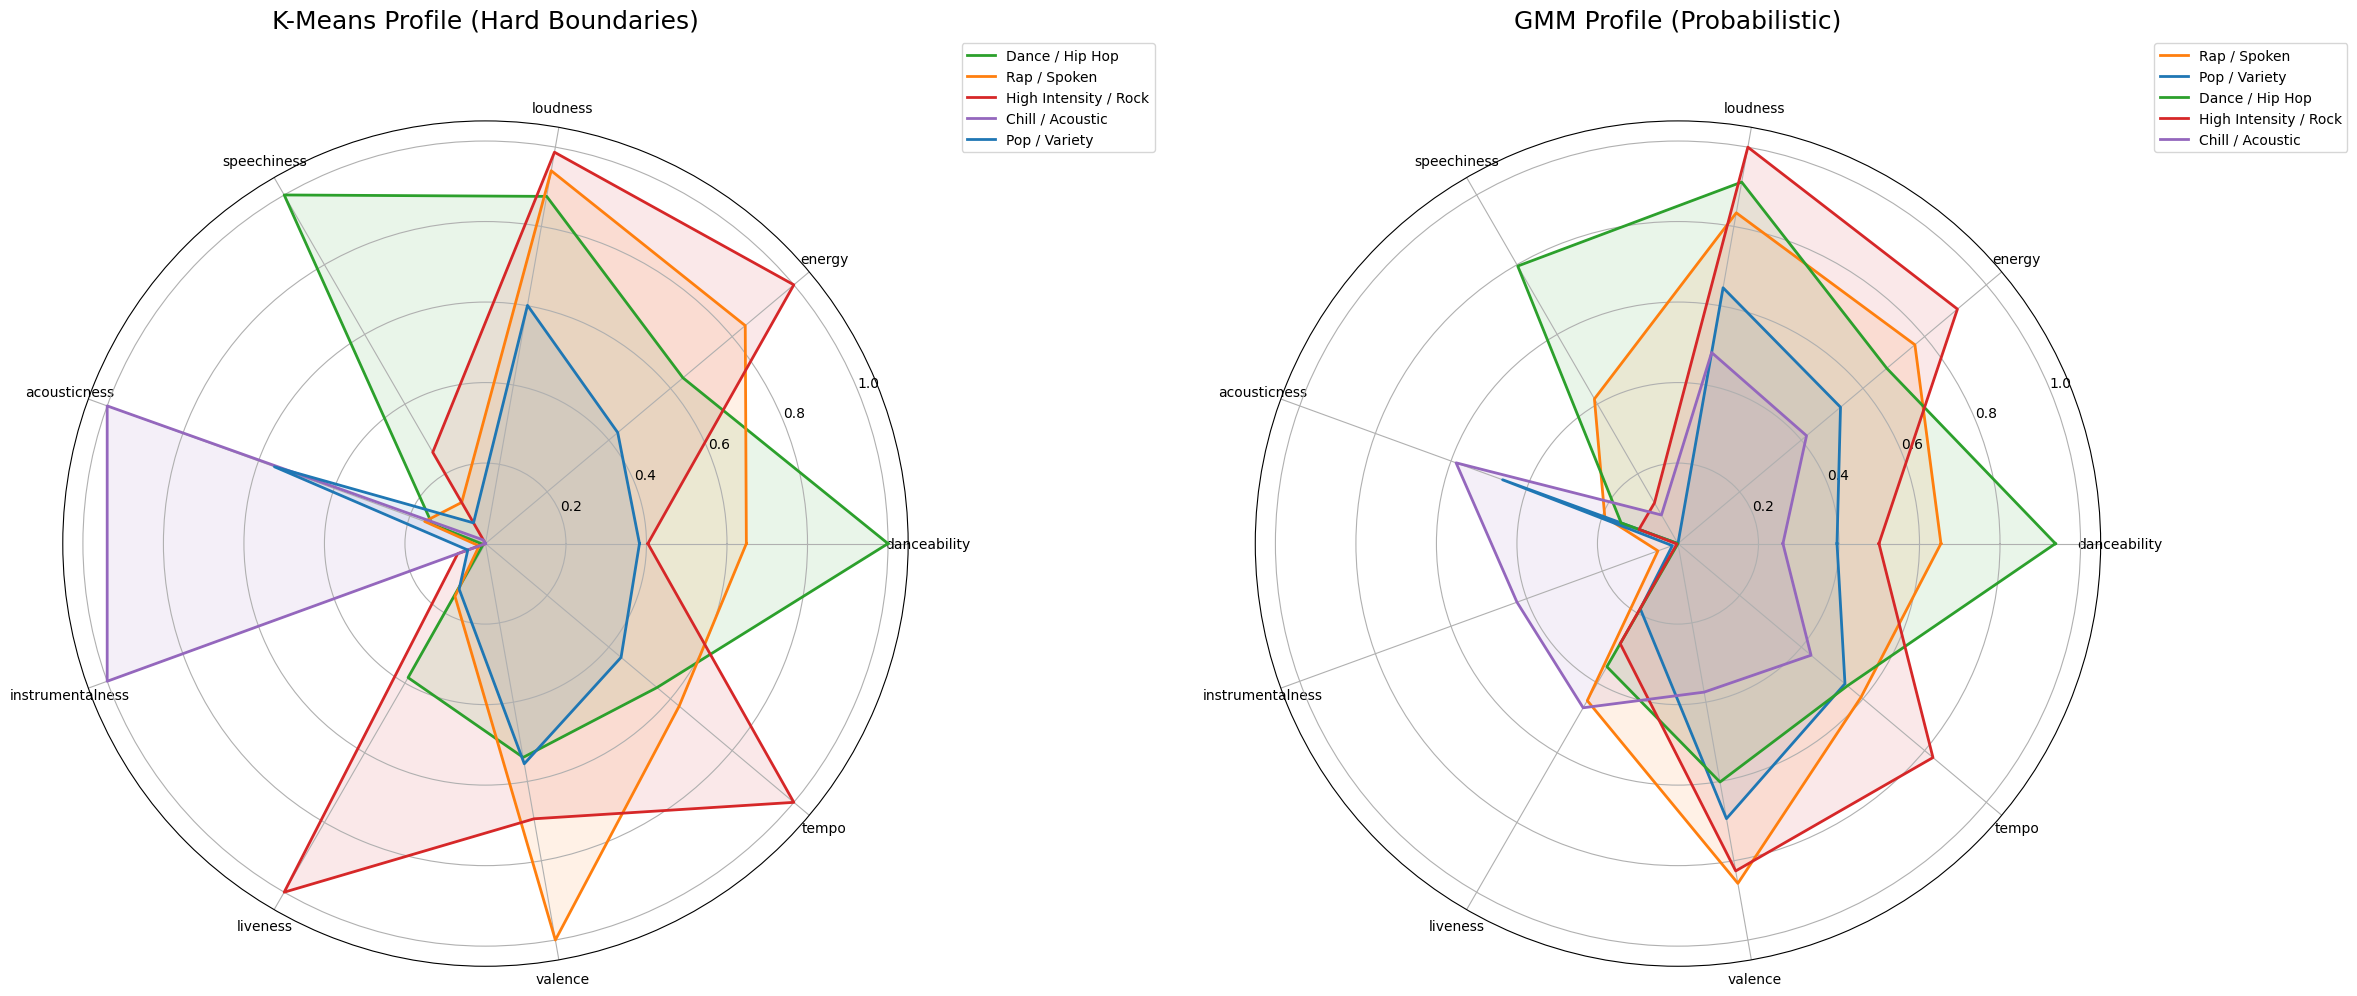

Running t-SNE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


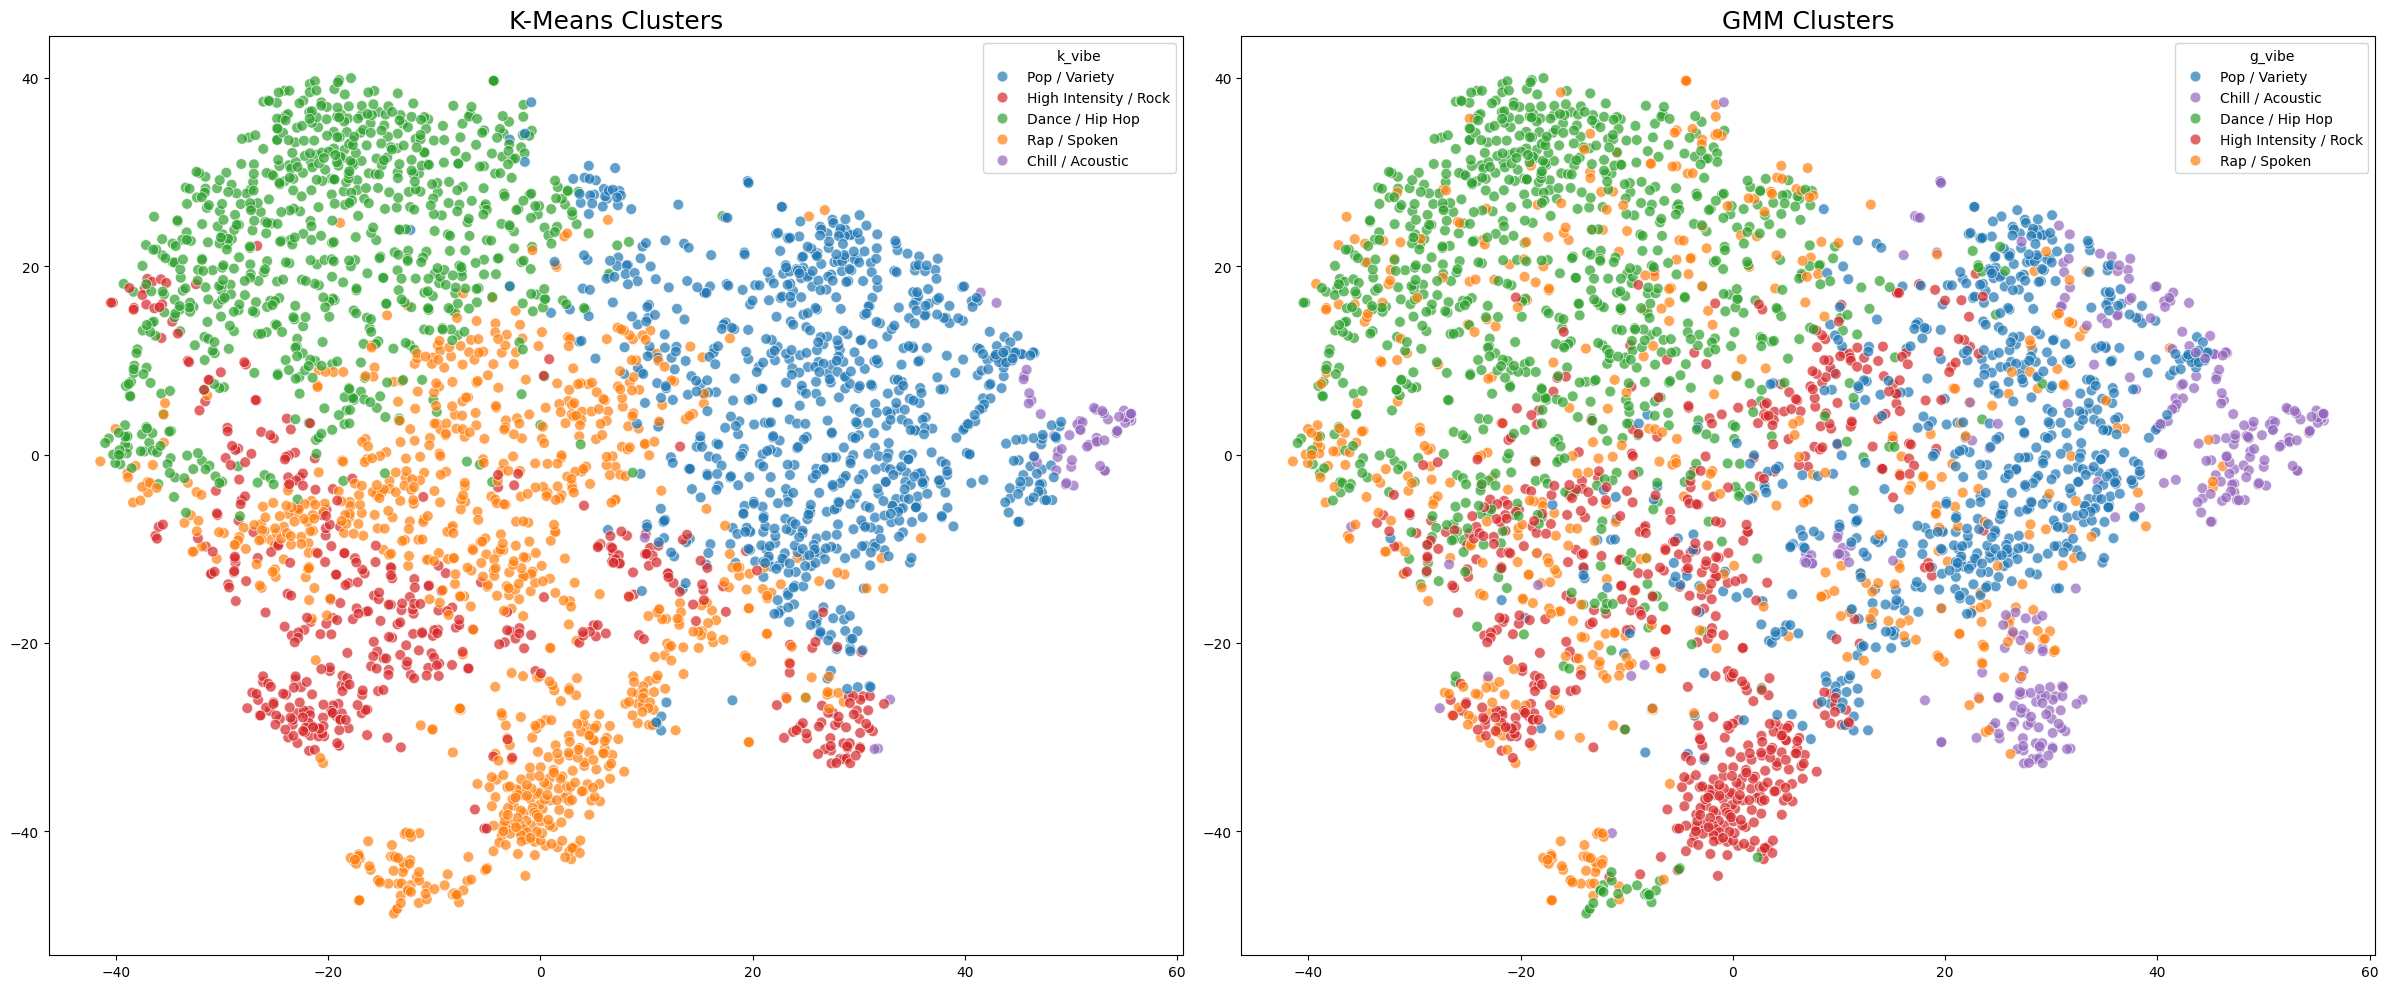

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from math import pi

# ==========================================
# 1. DEFINE NAMING LOGIC (The Source of Truth)
# ==========================================
def assign_relative_names(df, label_col):
    """
    Scans the cluster averages and assigns names based on
    which cluster is the 'King' of a specific feature.
    """
    feature_cols = [c for c in df.columns if '_mean' in c]
    stats = df.groupby(label_col)[feature_cols].mean()
    names = {}

    # 1. Find "Chill / Acoustic" (Max Acousticness)
    id_acoustic = stats['acousticness_mean'].idxmax()
    names[id_acoustic] = "Chill / Acoustic"

    # 2. Find "High Intensity / Rock" (Max Energy from remainder)
    remaining = stats.drop(index=[id_acoustic])
    id_energy = remaining['energy_mean'].idxmax()
    names[id_energy] = "High Intensity / Rock"

    # 3. Find "Dance / Hip Hop" (Max Danceability from remainder)
    remaining = remaining.drop(index=[id_energy])
    if not remaining.empty:
        id_dance = remaining['danceability_mean'].idxmax()
        names[id_dance] = "Dance / Hip Hop"
        remaining = remaining.drop(index=[id_dance])

    # 4. Find "Rap / Spoken" (Max Speechiness from remainder)
    if not remaining.empty:
        id_speech = remaining['speechiness_mean'].idxmax()
        names[id_speech] = "Rap / Spoken"
        remaining = remaining.drop(index=[id_speech])

    # 5. Rest is "Pop / Variety"
    for idx in remaining.index:
        names[idx] = "Pop / Variety"

    return names

# --- APPLY NAMING ---
k_names_map = assign_relative_names(df_final, 'kmeans_label')
g_names_map = assign_relative_names(df_final, 'gmm_label')

# Save readable names to DataFrame
df_final['k_vibe'] = df_final['kmeans_label'].map(k_names_map)
df_final['g_vibe'] = df_final['gmm_label'].map(g_names_map)

# --- DEFINE FIXED COLORS (So Rock is always Red, Chill always Purple, etc.) ---
# This ensures K-Means and GMM look visually comparable
vibe_colors = {
    "High Intensity / Rock": "tab:red",
    "Chill / Acoustic":      "tab:purple",
    "Dance / Hip Hop":       "tab:green",
    "Rap / Spoken":          "tab:orange",
    "Pop / Variety":         "tab:blue"
}

# ==========================================
# 2. PLOT RADAR COMPARISON
# ==========================================
def plot_radar_consistent(df, k_names, g_names):
    # Prepare Data
    feature_cols = [c for c in df.columns if '_mean' in c]
    k_means = df.groupby('kmeans_label')[feature_cols].mean()
    g_means = df.groupby('gmm_label')[feature_cols].mean()

    # Normalize combined data (0-1)
    combined_means = pd.concat([k_means, g_means])
    scaler_plot = MinMaxScaler()
    scaler_plot.fit(combined_means)

    k_norm = pd.DataFrame(scaler_plot.transform(k_means), columns=[c.replace('_mean','') for c in feature_cols])
    g_norm = pd.DataFrame(scaler_plot.transform(g_means), columns=[c.replace('_mean','') for c in feature_cols])

    # Setup Plot
    N = len(feature_cols)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(24, 10))

    # Function to draw one radar
    def draw_radar(ax, norm_df, name_map, title):
        ax.set_title(title, size=18, y=1.1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(norm_df.columns, size=10)

        # Sort indices to ensure legend order consistency if desired,
        # or just iterate 0..4
        for i in range(len(norm_df)):
            values = norm_df.iloc[i].values.flatten().tolist()
            values += values[:1]

            # Get Name and Color
            vibe_name = name_map[i]
            color_code = vibe_colors.get(vibe_name, 'grey')

            ax.plot(angles, values, linewidth=2, linestyle='solid', label=vibe_name, color=color_code)
            ax.fill(angles, values, color=color_code, alpha=0.1)

        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # Plot K-Means
    ax1 = fig.add_subplot(121, polar=True)
    draw_radar(ax1, k_norm, k_names, "K-Means Profile (Hard Boundaries)")

    # Plot GMM
    ax2 = fig.add_subplot(122, polar=True)
    draw_radar(ax2, g_norm, g_names, "GMM Profile (Probabilistic)")

    plt.tight_layout()
    plt.show()

plot_radar_consistent(df_final, k_names_map, g_names_map)


# ==========================================
# 3. PLOT SCATTER COMPARISON (t-SNE)
# ==========================================
print("Running t-SNE...")
np.random.seed(42)
indices = np.random.choice(X_scaled.shape[0], 3000, replace=False)
# Ensure we strictly use the scaled data
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(X_scaled[indices])

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plot K-Means
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=df_final['k_vibe'].iloc[indices],
    palette=vibe_colors, # <--- KEY: Using exact same colors as Radar
    s=60, alpha=0.7, ax=axes[0]
)
axes[0].set_title('K-Means Clusters', fontsize=18)

# Plot GMM
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=df_final['g_vibe'].iloc[indices],
    palette=vibe_colors, # <--- KEY: Using exact same colors as Radar
    s=60, alpha=0.7, ax=axes[1]
)
axes[1].set_title('GMM Clusters', fontsize=18)

plt.tight_layout()
plt.show()

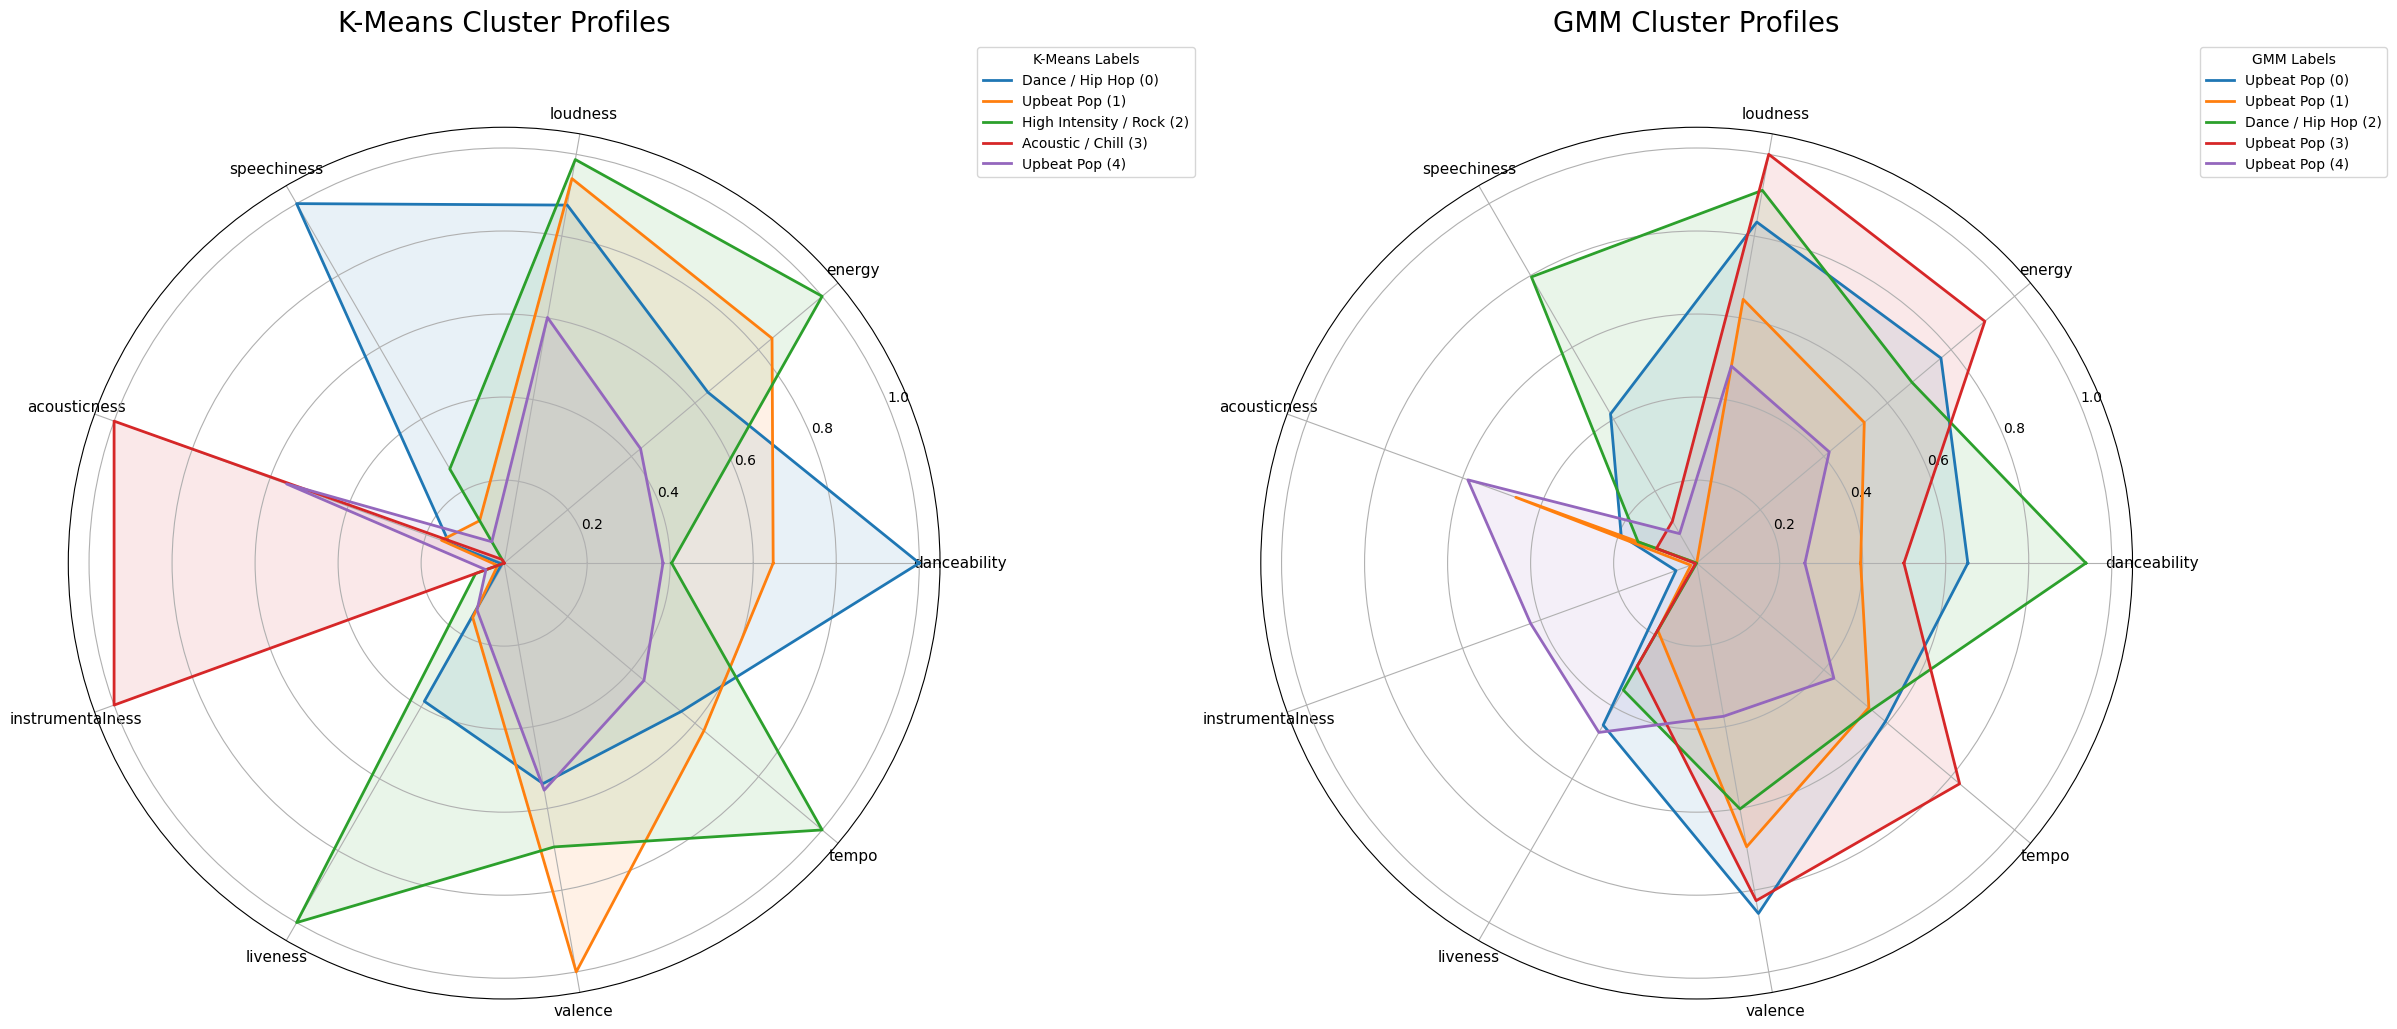

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from math import pi

def plot_radar_comparison(df, k_label_col, g_label_col, k_names, g_names):
    # 1. Prepare Data
    feature_cols = [c for c in df.columns if '_mean' in c]

    # Calculate means for K-Means
    k_means = df.groupby(k_label_col)[feature_cols].mean()
    # Calculate means for GMM
    g_means = df.groupby(g_label_col)[feature_cols].mean()

    # Normalize (0-1) for visualization
    # Important: Fit the scaler on the COMBINED data so the scale is consistent across both plots
    combined_means = pd.concat([k_means, g_means])
    scaler_plot = MinMaxScaler()
    scaler_plot.fit(combined_means)

    k_norm = pd.DataFrame(scaler_plot.transform(k_means),
                          columns=[c.replace('_mean','') for c in feature_cols])
    g_norm = pd.DataFrame(scaler_plot.transform(g_means),
                          columns=[c.replace('_mean','') for c in feature_cols])

    # 2. Setup Plot
    N = len(feature_cols)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Close the loop

    fig = plt.figure(figsize=(24, 12))

    # Define Colors
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

    # --- PLOT 1: K-MEANS ---
    ax1 = fig.add_subplot(121, polar=True)
    ax1.set_title("K-Means Cluster Profiles", size=20, y=1.1)

    for i in range(len(k_norm)):
        values = k_norm.iloc[i].values.flatten().tolist()
        values += values[:1]

        label_text = k_names.get(i, f"Cluster {i}")
        ax1.plot(angles, values, linewidth=2, label=label_text, color=colors[i % len(colors)])
        ax1.fill(angles, values, color=colors[i % len(colors)], alpha=0.1)

    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(k_norm.columns, size=11)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title="K-Means Labels")

    # --- PLOT 2: GMM ---
    ax2 = fig.add_subplot(122, polar=True)
    ax2.set_title("GMM Cluster Profiles", size=20, y=1.1)

    for i in range(len(g_norm)):
        values = g_norm.iloc[i].values.flatten().tolist()
        values += values[:1]

        label_text = g_names.get(i, f"Cluster {i}")
        ax2.plot(angles, values, linewidth=2, label=label_text, color=colors[i % len(colors)])
        ax2.fill(angles, values, color=colors[i % len(colors)], alpha=0.1)

    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(g_norm.columns, size=11)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), title="GMM Labels")

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
plot_radar_comparison(df_final, 'kmeans_label', 'gmm_label', k_names, g_names)

## Debug Nama Cluster

K-Means Names: {np.int32(3): 'Chill / Acoustic (3)', np.int32(2): 'High Intensity / Rock (2)', np.int32(0): 'Dance / Hip Hop (0)', np.int32(1): 'Rap / Spoken (1)', 4: 'Pop / Variety (4)'}
GMM Names:     {np.int64(4): 'Chill / Acoustic (4)', np.int64(3): 'High Intensity / Rock (3)', np.int64(2): 'Dance / Hip Hop (2)', np.int64(0): 'Rap / Spoken (0)', 1: 'Pop / Variety (1)'}

Plotting Comparison...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


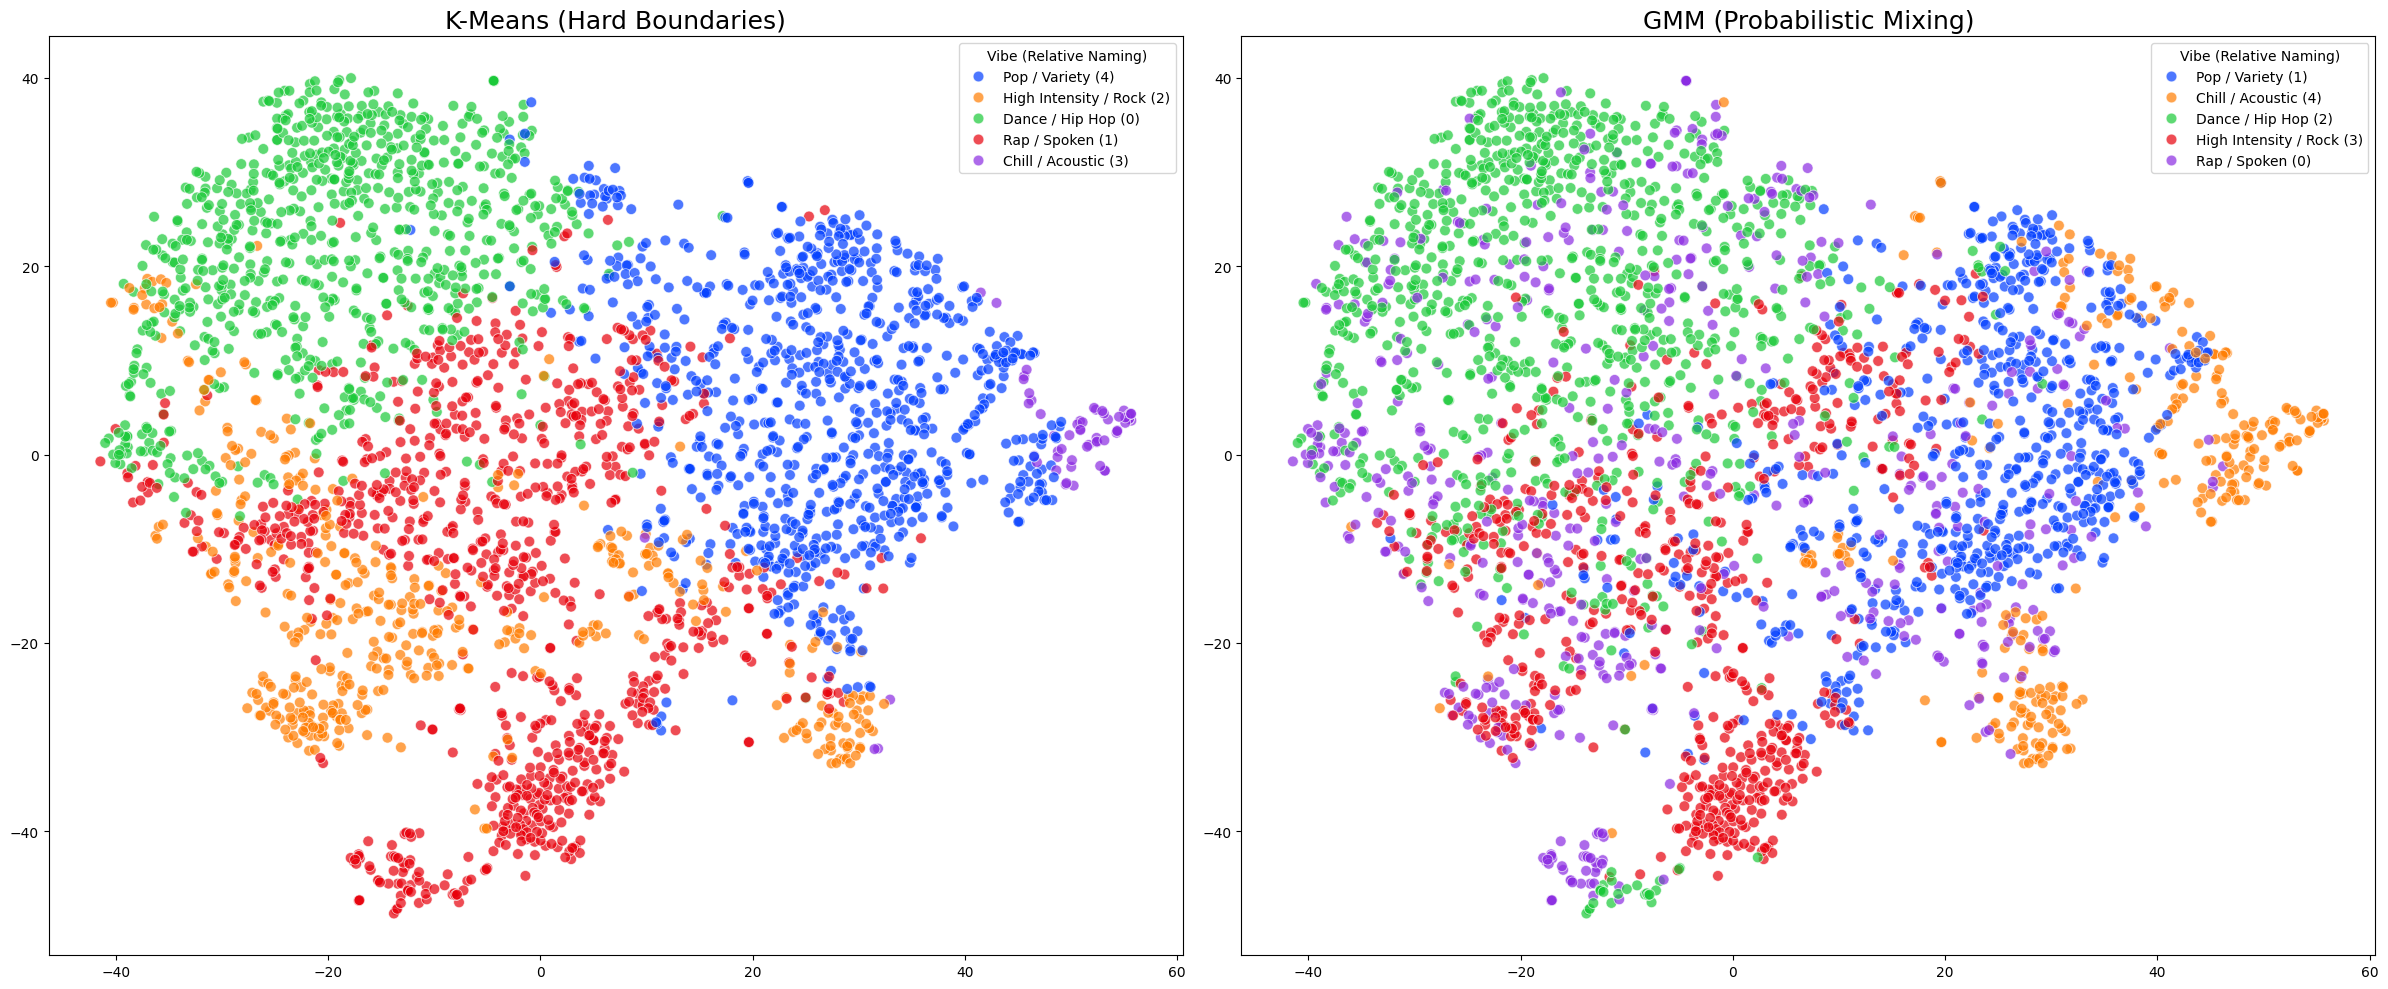

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# 1. FIXED NAMING STRATEGY (Relative Ranking)
def assign_relative_names(df, label_col):
    # Calculate means for every feature per cluster
    # We focus on the RAW means (unscaled) if possible, or scaled if that's what we have.
    # We look for columns with '_mean'
    feature_cols = [c for c in df.columns if '_mean' in c]
    stats = df.groupby(label_col)[feature_cols].mean()

    # Create a mapping dictionary
    names = {}

    # 1. Find the "Acoustic" Cluster (Max Acousticness)
    id_acoustic = stats['acousticness_mean'].idxmax()
    names[id_acoustic] = f"Chill / Acoustic ({id_acoustic})"

    # 2. Find the "High Intensity" Cluster (Max Energy)
    # We exclude the acoustic one we just found to avoid overwriting
    remaining = stats.drop(index=[id_acoustic])
    id_energy = remaining['energy_mean'].idxmax()
    names[id_energy] = f"High Intensity / Rock ({id_energy})"

    # 3. Find the "Dance" Cluster (Max Danceability)
    remaining = remaining.drop(index=[id_energy])
    if not remaining.empty:
        id_dance = remaining['danceability_mean'].idxmax()
        names[id_dance] = f"Dance / Hip Hop ({id_dance})"
        remaining = remaining.drop(index=[id_dance])

    # 4. Find the "Speech" Cluster (Max Speechiness - often Rap)
    if not remaining.empty:
        id_speech = remaining['speechiness_mean'].idxmax()
        names[id_speech] = f"Rap / Spoken ({id_speech})"
        remaining = remaining.drop(index=[id_speech])

    # 5. Label the rest as "Pop / Mixed"
    for idx in remaining.index:
        names[idx] = f"Pop / Variety ({idx})"

    return names

# APPLY THE NEW NAMES
k_names_map = assign_relative_names(df_final, 'kmeans_label')
g_names_map = assign_relative_names(df_final, 'gmm_label')

df_final['k_vibe'] = df_final['kmeans_label'].map(k_names_map)
df_final['g_vibe'] = df_final['gmm_label'].map(g_names_map)

print("K-Means Names:", k_names_map)
print("GMM Names:    ", g_names_map)


# 2. GENERATE SIDE-BY-SIDE PLOT
print("\nPlotting Comparison...")

# Use the same t-SNE results for both (Fair comparison)
# (Assuming tsne_results, indices, and X_sample exist from previous step.
# If not, uncomment lines below to re-run t-SNE)

# --- RE-RUN t-SNE (Just in case variables were lost) ---
np.random.seed(42)
indices = np.random.choice(X_scaled.shape[0], 3000, replace=False)
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(X_scaled[indices])
# -----------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# PLOT 1: K-MEANS
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=df_final['k_vibe'].iloc[indices],
    palette='bright', s=60, alpha=0.7, ax=axes[0]
)
axes[0].set_title('K-Means (Hard Boundaries)', fontsize=18)
axes[0].legend(title="Vibe (Relative Naming)", loc='upper right')

# PLOT 2: GMM
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=df_final['g_vibe'].iloc[indices],
    palette='bright', s=60, alpha=0.7, ax=axes[1]
)
axes[1].set_title('GMM (Probabilistic Mixing)', fontsize=18)
axes[1].legend(title="Vibe (Relative Naming)", loc='upper right')

plt.tight_layout()
plt.show()

In [46]:
# --- CLUSTER AUDIT TOOL ---
def audit_cluster_difference(df, k_label, g_label):
    print(f"--- K-MEANS RAP CLUSTER ({k_label}) ---")
    # Filter for K-Means Rap Cluster
    k_subset = df[df['kmeans_label'] == k_label]
    print(f"Total Playlists: {len(k_subset)}")
    print("Top 25 Playlist Names:")
    print(pd.DataFrame(k_subset['playlist_name'].head(50)).to_markdown(index=False))
    print(f"Avg Speechiness: {k_subset['speechiness_mean'].mean():.3f}")
    print(f"Avg Pop: {k_subset['energy_mean'].mean():.3f}")

    print(f"\n--- GMM RAP CLUSTER ({g_label}) ---")
    # Filter for GMM Rap Cluster
    g_subset = df[df['gmm_label'] == g_label]
    print(f"Total Playlists: {len(g_subset)}")
    print("Top 25 Playlist Names:")
    print(pd.DataFrame(g_subset['playlist_name'].head(50)).to_markdown(index=False))
    print(f"Avg Speechiness: {g_subset['speechiness_mean'].mean():.3f}")
    print(f"Avg Pop: {g_subset['energy_mean'].mean():.3f}")

# Look at your legend to get the IDs:
# K-Means Rap = 1 (Red in your image)
# GMM Rap = 0 (Purple in your image)
audit_cluster_difference(df_final, k_label=1, g_label=0)

--- K-MEANS RAP CLUSTER (1) ---
Total Playlists: 8942
Top 25 Playlist Names:
| playlist_name   |
|:----------------|
| korean          |
| Wedding         |
| 90's            |
| SARAH           |
| fall '17        |
| groovy          |
| good good       |
| Good Vibes      |
| tb              |
| Country         |
| Belters         |
| Road Trippin'   |
| angst           |
| Country         |
| SB              |
| Tennessee       |
| Favorite Songs  |
| Ski             |
| spanish jams    |
| Gym             |
| Catchy Songs    |
| latin           |
| party people    |
| Worship         |
| country         |
| 4/20            |
| beach           |
| oldies          |
| go to           |
| Fall            |
| Love Music      |
| English         |
| motown          |
| motivational    |
| basic           |
| feelz           |
| Alexia          |
| Daddy Issues    |
| Love            |
| running         |
| Bus playlist    |
| Latino          |
| On the Run      |
| my country      |
| V